## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pypfopt.plotting as plotting
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

from custom_allocation import CustomDiscreteAllocation

C:\Users\ruchd\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import requests
from bs4 import BeautifulSoup

# URL of the Wikipedia page containing the S&P 500 components
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Send a GET request to the URL and get the page content
response = requests.get(url)
content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(content, 'html.parser')

# Find the table containing the stock data
table = soup.find('table', {'class': 'wikitable sortable'})

# Find all rows in the table
rows = table.find_all('tr')

# Iterate over the rows and extract the stock symbols
sp500_stocks = []
for row in rows[1:]:
    cells = row.find_all('td')
    stock_symbol = cells[0].text.strip()
    sp500_stocks.append(stock_symbol)

# Print the list of S&P 500 stocks
for stock in sp500_stocks:
    print(stock)

MMM
AOS
ABT
ABBV
ACN
ATVI
ADM
ADBE
ADP
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AMD
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ANET
AJG
AIZ
T
ATO
ADSK
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BBWI
BAX
BDX
WRB
BRK.B
BBY
BIO
TECH
BIIB
BLK
BK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF.B
BG
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
CNC
CNP
CDAY
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CTVA
CSGP
COST
CTRA
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
FANG
DLR
DFS
DIS
DG
DLTR
D
DPZ
DOV
DOW
DTE
DUK
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
LLY
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ESS
EL
ETSY
RE
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FITB
FSLR
FE
FIS
FI
FLT
FMC
F
FTNT
FTV
FOXA
FOX
BEN
FCX
GRMN
IT
GEHC
GEN
GNRC
GD
GE
GIS
GM
GPC
GILD
GL
GPN
GS
HAL
HIG
HAS
HCA
PEAK
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST


In [3]:
len(sp500_stocks)

503

In [4]:
import random

# Set the seed for reproducibility
random.seed(42)

# Generate random selection of 20 stocks
random_stocks = random.sample(sp500_stocks, 20)

# Print the randomly selected stocks
for stock in random_stocks:
    print(stock)

MCO
AXON
A
PPG
DHI
COP
C
BK
PNC
ATO
NCLH
TYL
KLAC
AAPL
MMC
GNRC
ALB
ALK
ACGL
CINF


## Getting the Data

In [5]:
start_date = date(2020,1,1)
end_date = date(2020, 12, 31)

# Define the ticker list
tickers_list = random_stocks

# Fetch the training data
import yfinance as yf


train_data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']

# Print the available tickers
#print(train_data.keys())
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  20 of 20 completed


In [6]:
# Download benchmark data - We can also use Buffet's Portfolio as a Benchmark
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


## Applying Markowitz

In [7]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = train_data


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
#Add shrinkage here
#https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html#pypfopt.risk_models.CovarianceShrinkage
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
#ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))
ef = EfficientFrontier(returns, cov_matrix, weight_bounds = (0.0,0.15))

# Efficient Frontier with random portfolios

Maximise the Sharpe Ratio. The result is also referred to as the tangency portfolio, as it is the portfolio for which the capital market line is tangent to the efficient frontier.

This is a convex optimization problem after making a certain variable substitution. See Cornuejols and Tutuncu (2006) for more.

Because max_sharpe() makes a variable substitution, additional objectives may not work as intended.

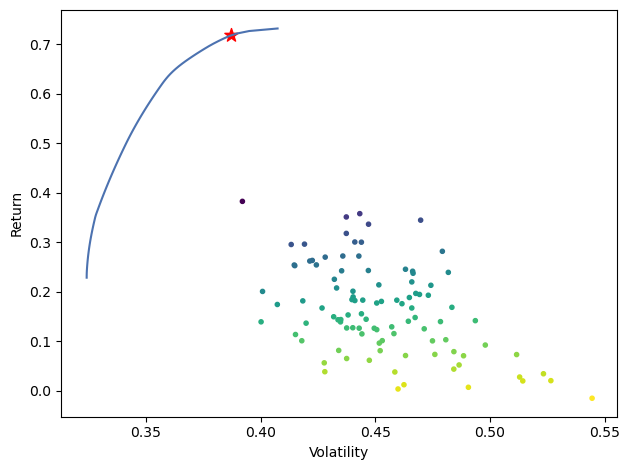

In [8]:
fig, ax = plt.subplots()
ef_optimize = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

### Choosing Optimization Strategy (Comment out the other approach you want to use)

### adding gamma for diversification - https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#l2-regularisation
#ef_optimize.add_objective(objective_functions.L2_reg, gamma=1.5)


### adding transaction costs objective function - https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb
# Pretend that you started with a default-weight allocation
#initial_weights = np.array([1/len(tickers_list)] * len(tickers_list))
#ef_optimize.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)

#For Min Volatility
#ef_optimize.min_volatility()

#For Max Sharpe - 
#max_sharpe transforms the optimization problem so additional objectives eg. transaction costs, gamma may not work as expected.

ef_optimize.max_sharpe()

# Markowitz with Target Volatility

#target_volatility = 0.2
#ef_optimize.efficient_risk(target_volatility)

# Find the tangency portfolio

ret_tangent, std_tangent, _ = ef_optimize.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# Normalize weights to sum up to 1 - to make sure they lie within efficient frontier
w = w / np.sum(w, axis=1, keepdims=True)  
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
ax.get_legend().remove()
plt.tight_layout()
#Saves the output file as a transparent image
plt.savefig("ef_scatter.png", dpi=200, transparent=True)
plt.show()

In [9]:
# Print Weights - Max Sharpe
cleaned_weights = ef_optimize.clean_weights()
print(cleaned_weights)

OrderedDict([('A', 0.15), ('AAPL', 0.15), ('ACGL', 0.0), ('ALB', 0.15), ('ALK', 0.0), ('ATO', 0.0), ('AXON', 0.15), ('BK', 0.0), ('C', 0.0), ('CINF', 0.0), ('COP', 0.0), ('DHI', 0.09883), ('GNRC', 0.15), ('KLAC', 0.00117), ('MCO', 0.0), ('MMC', 0.0), ('NCLH', 0.0), ('PNC', 0.0), ('PPG', 0.0), ('TYL', 0.15)])


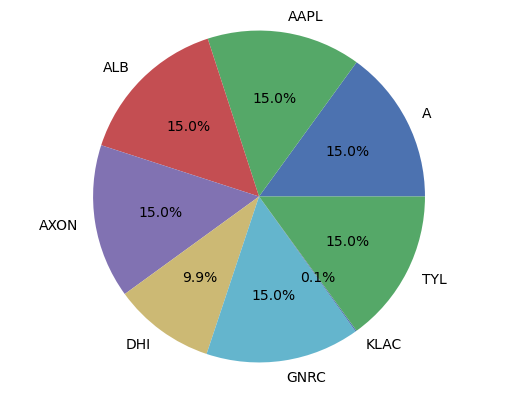

<Figure size 640x480 with 0 Axes>

In [10]:
filtered_dict = {key: value for key, value in cleaned_weights.items() if value != 0}
labels = list(filtered_dict.keys()) 
values = list(filtered_dict.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
#plt.title('Stock Asset Allocation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
plt.savefig('Asset Allocation.png')

## In-Sample Portfolio Performance

In [11]:
#to know the expected performance of the portfolio with optimal weights w
ef_optimize.portfolio_performance(verbose=True)

Expected annual return: 71.8%
Annual volatility: 38.7%
Sharpe Ratio: 1.80


(0.71799310655806, 0.3871179844006111, 1.8030500640232154)

## Comparison with Benchmark Chart

In [12]:
# Create an empty Series to store portfolio returns
portfolio_returns_1 = pd.Series()
portfolio_returns_1.index.name = 'Date'

# Extract unique years
unique_years = historical_prices.index.year.unique()

C:\Users\ruchd\AppData\Local\Temp\ipykernel_19772\806986570.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_returns_1 = pd.Series()


In [13]:
# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = historical_prices[historical_prices.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = historical_prices[historical_prices.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_returns_1 = pd.concat([portfolio_returns_1, current_year_portfolio_returns])

### In sample graph comparison with Benchmark

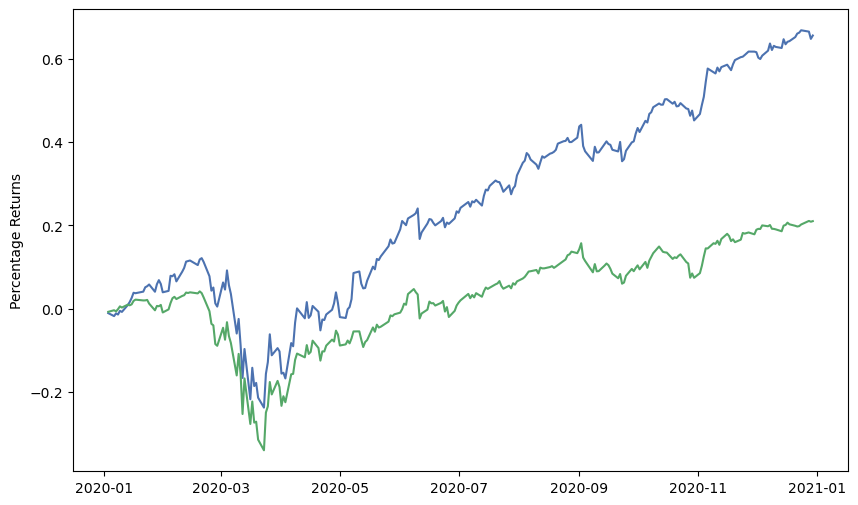

In [14]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_returns_1
benchmark_returns = spy_data.pct_change().dropna()

# Calculate portfolio and benchmark values
#portfolio_values = (1 + portfolio_returns).cumprod() * 10000
#benchmark_values = (1 + benchmark_returns).cumprod() * 10000

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
#plt.legend()
#plt.xlabel('Date')
plt.ylabel('Percentage Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy_IN_Mark.png', transparent=True)

## Markowitz with Monthly Rebalancing keeping Original Weights Only

TODO

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months

TODO

# Hierarchical Risk Parity
HRP is a modern portfolio optimization method inspired by machine learning.

The idea is that by examining the hierarchical structure of the market, we can better diversify.

In [15]:
rets = expected_returns.returns_from_prices(historical_prices)

In [16]:
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('A', 0.06431),
             ('AAPL', 0.0707),
             ('ACGL', 0.03829),
             ('ALB', 0.0529),
             ('ALK', 0.02546),
             ('ATO', 0.08907),
             ('AXON', 0.04568),
             ('BK', 0.0463),
             ('C', 0.01279),
             ('CINF', 0.03182),
             ('COP', 0.0212),
             ('DHI', 0.03106),
             ('GNRC', 0.03946),
             ('KLAC', 0.04058),
             ('MCO', 0.03401),
             ('MMC', 0.12227),
             ('NCLH', 0.0098),
             ('PNC', 0.01748),
             ('PPG', 0.06632),
             ('TYL', 0.14051)])

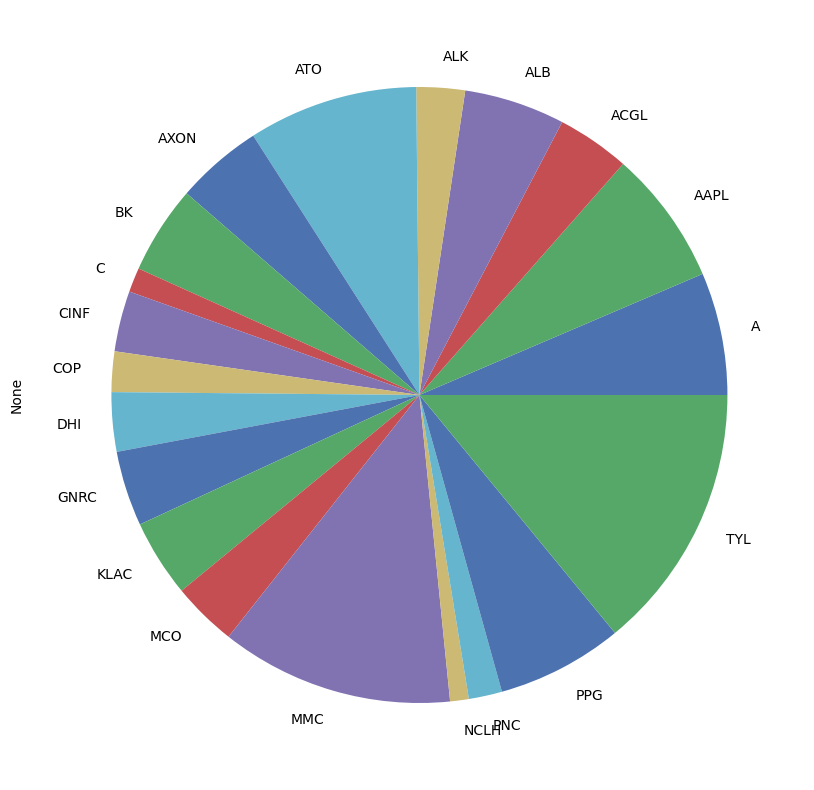

In [17]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [18]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 31.5%
Annual volatility: 36.9%
Sharpe Ratio: 0.80


### Plotting

Plotting a dendrogram (tree diagram) based on the hierarchical structure of asset returns

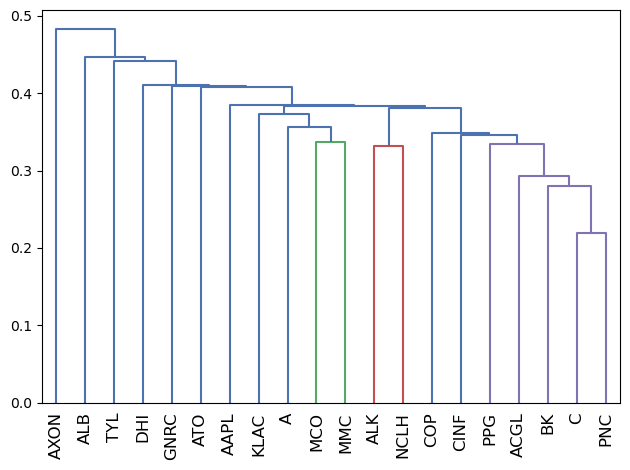

In [19]:
plotting.plot_dendrogram(hrp); 

## Simulation

#### Data Universe
Training Data start_date = '2020-01-01'

Training Data end_date = '2020-12-31'

Testing Data = 

In [20]:
print(end_date)

next_day = end_date + timedelta(days=1)

# We invest on the next day using cleaned_weights

print(next_day)

# Now we keep the target weights same for 1 year

next_year = end_date + relativedelta(years=1)

print(next_year)

2020-12-31
2021-01-01
2021-12-31


In [21]:
test_data = yf.download(tickers_list, start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [22]:
testing_years = test_data.index.year.unique()
testing_months = test_data.index.month.unique()

print(testing_years, testing_months)

Int64Index([2021], dtype='int64', name='Date') Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='Date')


In [23]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = test_data.iloc[0]  # Latest prices for the assets - as on 1 Jan 2021
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
old_allocation, leftover = da.greedy_portfolio(verbose=True)

Funds remaining: 11.54
A: allocated 0.140, desired 0.150
AAPL: allocated 0.140, desired 0.150
ALB: allocated 0.150, desired 0.150
AXON: allocated 0.140, desired 0.150
GNRC: allocated 0.157, desired 0.150
TYL: allocated 0.173, desired 0.150
DHI: allocated 0.099, desired 0.099
KLAC: allocated 0.000, desired 0.001
ACGL: allocated 0.000, desired 0.000
ALK: allocated 0.000, desired 0.000
ATO: allocated 0.000, desired 0.000
BK: allocated 0.000, desired 0.000
C: allocated 0.000, desired 0.000
CINF: allocated 0.000, desired 0.000
COP: allocated 0.000, desired 0.000
MCO: allocated 0.000, desired 0.000
MMC: allocated 0.000, desired 0.000
NCLH: allocated 0.000, desired 0.000
PNC: allocated 0.000, desired 0.000
PPG: allocated 0.000, desired 0.000
Allocation has RMSE: 0.007


Optimal Allocation: {'AAPL': 16, 'AMD': 22, 'BABA': 3, 'GOOG': 23, 'RRC': 177, 'WMT': 14}

Funds remaining: 99.28
AAPL: allocated 0.190, desired 0.200
AMD: allocated 0.214, desired 0.200
BA: allocated 0.000, desired 0.000
BABA: allocated 0.025, desired 0.075
BAC: allocated 0.000, desired 0.000
GE: allocated 0.000, desired 0.000
GM: allocated 0.000, desired 0.000
GOOG: allocated 0.225, desired 0.200
JPM: allocated 0.000, desired 0.000
MU: allocated 0.000, desired 0.000
PFE: allocated 0.000, desired 0.000
RRC: allocated 0.214, desired 0.125
SBUX: allocated 0.000, desired 0.000
T: allocated 0.000, desired 0.000
UAA: allocated 0.000, desired 0.000
WMT: allocated 0.131, desired 0.200
XOM: allocated 0.000, desired 0.000
Allocation has RMSE: 0.031
Allocation: {'AAPL': 16, 'AMD': 22, 'BABA': 3, 'GOOG': 23, 'RRC': 177, 'WMT': 14}
Leftover: 99.2767562866211

In [24]:
print(cleaned_weights)

OrderedDict([('A', 0.15), ('AAPL', 0.15), ('ACGL', 0.0), ('ALB', 0.15), ('ALK', 0.0), ('ATO', 0.0), ('AXON', 0.15), ('BK', 0.0), ('C', 0.0), ('CINF', 0.0), ('COP', 0.0), ('DHI', 0.09883), ('GNRC', 0.15), ('KLAC', 0.00117), ('MCO', 0.0), ('MMC', 0.0), ('NCLH', 0.0), ('PNC', 0.0), ('PPG', 0.0), ('TYL', 0.15)])


In [25]:
print("Optimal Allocation:", old_allocation)
print("Leftover:", leftover)
print (10000-leftover)

Optimal Allocation: {'A': 12, 'AAPL': 11, 'ALB': 10, 'AXON': 12, 'GNRC': 7, 'TYL': 4, 'DHI': 15}
Leftover: 11.535713195800781
9988.4642868042


### Now we calculate the portfolio value after one month and effective weights after one month - which is ratio of current assets vs Portfolio Value

In [26]:
#find first trading day of the next month

current_month_prices = test_data[(test_data.index.year == 2021) & (test_data.index.month == 12)]

current_month_prices = current_month_prices.sort_index()

#pandas series with stocks name as index, prices are values and date as index name
first_trading_day_prices = current_month_prices.iloc[-1]

In [27]:
#print(first_trading_day_prices)

In [28]:
print(old_allocation)

{'A': 12, 'AAPL': 11, 'ALB': 10, 'AXON': 12, 'GNRC': 7, 'TYL': 4, 'DHI': 15}


In [29]:
#print(first_trading_day_prices)

In [30]:
# Current Value of Each stock in allocated portfolio
result = first_trading_day_prices * pd.Series(old_allocation)

print(result)

A       1908.658081
AAPL    1943.230164
ACGL            NaN
ALB     2319.854584
ALK             NaN
ATO             NaN
AXON    1872.840088
BK              NaN
C               NaN
CINF            NaN
COP             NaN
DHI     1586.102943
GNRC    2470.719940
KLAC            NaN
MCO             NaN
MMC             NaN
NCLH            NaN
PNC             NaN
PPG             NaN
TYL     2152.479980
dtype: float64


In [31]:
new_portfolio_value = result.sum()

In [32]:
new_portfolio_value

14253.885780334473

In [33]:
#comparison with benchmark
spy_test_data = yf.download('SPY', start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [34]:
print(spy_data)

10000/355.447

Date
2020-01-02    307.375641
2020-01-03    305.048187
2020-01-06    306.211884
2020-01-07    305.350922
2020-01-08    306.978271
                 ...    
2020-12-23    354.270996
2020-12-24    355.649170
2020-12-28    358.704468
2020-12-29    358.020142
2020-12-30    358.530975
Name: Adj Close, Length: 252, dtype: float64


28.13358953655538

In [35]:
current_effective_weights = result/new_portfolio_value

In [36]:
print(current_effective_weights)

A       0.133904
AAPL    0.136330
ACGL         NaN
ALB     0.162752
ALK          NaN
ATO          NaN
AXON    0.131392
BK           NaN
C            NaN
CINF         NaN
COP          NaN
DHI     0.111275
GNRC    0.173337
KLAC         NaN
MCO          NaN
MMC          NaN
NCLH         NaN
PNC          NaN
PPG          NaN
TYL     0.151010
dtype: float64


In [37]:
print(cleaned_weights)

OrderedDict([('A', 0.15), ('AAPL', 0.15), ('ACGL', 0.0), ('ALB', 0.15), ('ALK', 0.0), ('ATO', 0.0), ('AXON', 0.15), ('BK', 0.0), ('C', 0.0), ('CINF', 0.0), ('COP', 0.0), ('DHI', 0.09883), ('GNRC', 0.15), ('KLAC', 0.00117), ('MCO', 0.0), ('MMC', 0.0), ('NCLH', 0.0), ('PNC', 0.0), ('PPG', 0.0), ('TYL', 0.15)])


In [38]:
ordered_dict = cleaned_weights
x1 = old_allocation

print(x1)

{'A': 12, 'AAPL': 11, 'ALB': 10, 'AXON': 12, 'GNRC': 7, 'TYL': 4, 'DHI': 15}


## Comparison with Benchmark Chart - Test Data 

In [39]:
# Create an empty Series to store portfolio returns
portfolio_test_returns = pd.Series()
portfolio_test_returns.index.name = 'Date'

# Extract unique years
unique_years = test_data.index.year.unique()

# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = test_data[test_data.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = test_data[test_data.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_test_returns = pd.concat([portfolio_test_returns, current_year_portfolio_returns])

C:\Users\ruchd\AppData\Local\Temp\ipykernel_19772\1840264787.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_test_returns = pd.Series()


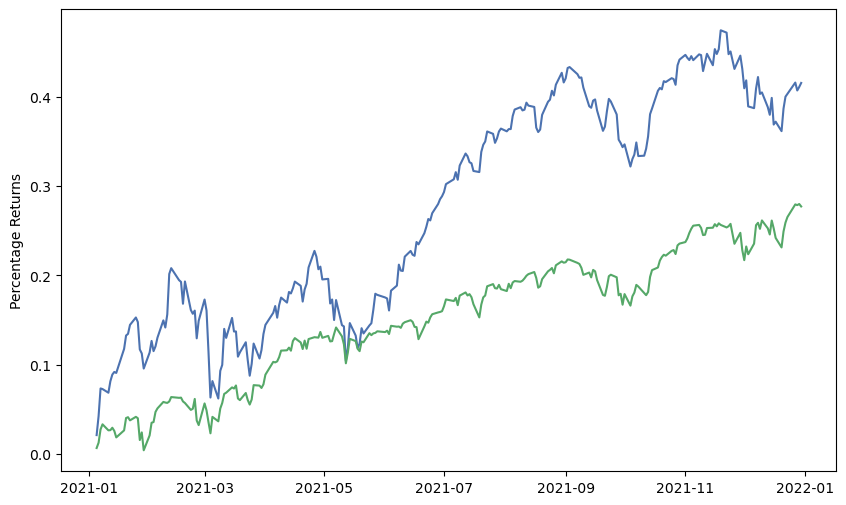

In [40]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_test_returns
benchmark_returns = spy_test_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
#plt.legend()
#plt.xlabel('Date')
plt.ylabel('Percentage Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy_out_Mark.png', transparent=True)

### working optimization problem

In [41]:
#min_value_constraints = {}
#for key, value in x1.items():
#    for index, (ordered_key, ordered_value) in enumerate(ordered_dict.items(), start=1):
#        if key == ordered_key:
#            new_key = int(index-1)
#            min_value_constraints[new_key] = value
#            break

In [42]:
#min_value_constraints

In [43]:
#total_portfolio_value = 15000

#### Instantiate the CustomDiscreteAllocation class
#da = CustomDiscreteAllocation(cleaned_weights, first_trading_day_prices, total_portfolio_value, min_value_constraints=min_value_constraints)

#### Call the lp_portfolio method with the additional constraint
#new_allocation, leftover = da.lp_portfolio(reinvest=True, verbose=True)

#### Print the allocation and leftover value
#print("Allocation:", new_allocation)
#print("Leftover:", leftover)

# Max Volatility with L2 diversification 

In [44]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
#historical_prices = train_data


# Calculate expected returns
#returns = expected_returns.mean_historical_return(historical_prices)
#Add shrinkage here
#https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html#pypfopt.risk_models.CovarianceShrinkage
#cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
#ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))
ef_optimize = EfficientFrontier(returns, cov_matrix)

In [45]:
### Choosing Optimization Strategy (Comment out the other approach you want to use)

### adding gamma for diversification - https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#l2-regularisation
ef_optimize.add_objective(objective_functions.L2_reg, gamma=1.5)


### adding transaction costs objective function - https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb
# Pretend that you started with a default-weight allocation
#initial_weights = np.array([1/len(tickers_list)] * len(tickers_list))
#ef_optimize.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)

#For Min Volatility
#ef_optimize.min_volatility()

#For Max Sharpe - 
#max_sharpe transforms the optimization problem so additional objectives eg. transaction costs, gamma may not work as expected.

#ef_optimize.max_sharpe()

#Markowitz with Target Volatility

target_volatility = 0.35
ef_optimize.efficient_risk(target_volatility)

# Find the tangency portfolio

#ret_tangent, std_tangent, _ = ef_optimize.portfolio_performance()
#ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
#n_samples = 100
#w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# Normalize weights to sum up to 1 - to make sure they lie within efficient frontier
#w = w / np.sum(w, axis=1, keepdims=True)  
#rets = w.dot(ef.expected_returns)
#stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
#sharpes = rets / stds
#ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
#ax.get_legend().remove()
#plt.tight_layout()
#Saves the output file as a transparent image
#plt.savefig("ef_scatter.png", dpi=200, transparent=True)
#plt.show()

OrderedDict([('A', 0.1353436403815482),
             ('AAPL', 0.13856232298574),
             ('ACGL', 1.183674e-10),
             ('ALB', 0.1128051742275635),
             ('ALK', 1.177233e-10),
             ('ATO', 0.0319183789982481),
             ('AXON', 0.0399526116751517),
             ('BK', 7.610563e-10),
             ('C', 8.32434e-11),
             ('CINF', 2.232501e-10),
             ('COP', 9.80249e-11),
             ('DHI', 1.80493068e-08),
             ('GNRC', 0.1658260766868391),
             ('KLAC', 1.98871e-10),
             ('MCO', 3.299372e-10),
             ('MMC', 0.0859194019111595),
             ('NCLH', 2.97925e-11),
             ('PNC', 1.659547e-10),
             ('PPG', 0.054180720879005),
             ('TYL', 0.2354916520794675)])

In [46]:
# Print Weights - Max Sharpe
cleaned_weights = ef_optimize.clean_weights()
print(cleaned_weights)

OrderedDict([('A', 0.13534), ('AAPL', 0.13856), ('ACGL', 0.0), ('ALB', 0.11281), ('ALK', 0.0), ('ATO', 0.03192), ('AXON', 0.03995), ('BK', 0.0), ('C', 0.0), ('CINF', 0.0), ('COP', 0.0), ('DHI', 0.0), ('GNRC', 0.16583), ('KLAC', 0.0), ('MCO', 0.0), ('MMC', 0.08592), ('NCLH', 0.0), ('PNC', 0.0), ('PPG', 0.05418), ('TYL', 0.23549)])


In [47]:
#to know the expected performance of the portfolio with optimal weights w
ef_optimize.portfolio_performance(verbose=True)

Expected annual return: 61.9%
Annual volatility: 35.0%
Sharpe Ratio: 1.71


(0.6186208091920907, 0.3500000006341385, 1.7103451660214142)

In [48]:
# Create an empty Series to store portfolio returns
portfolio_returns_1 = pd.Series()
portfolio_returns_1.index.name = 'Date'

# Extract unique years
unique_years = historical_prices.index.year.unique()

C:\Users\ruchd\AppData\Local\Temp\ipykernel_19772\806986570.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_returns_1 = pd.Series()


In [49]:
# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = historical_prices[historical_prices.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = historical_prices[historical_prices.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_returns_1 = pd.concat([portfolio_returns_1, current_year_portfolio_returns])

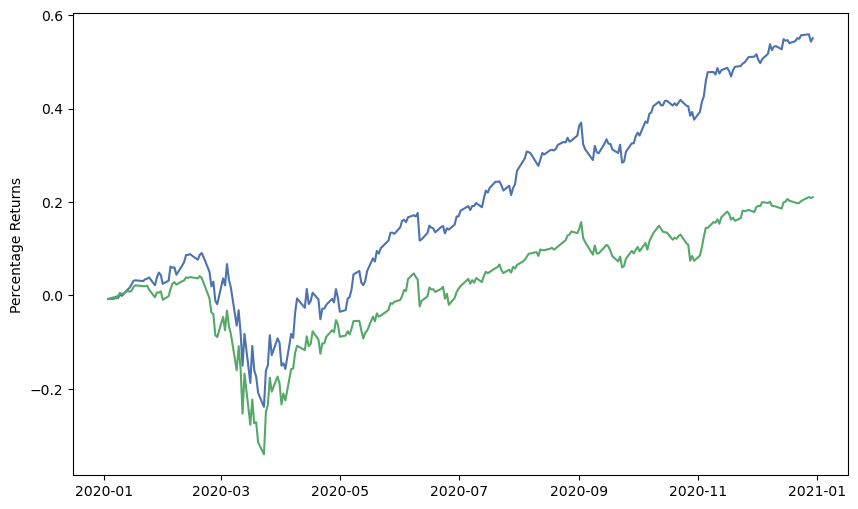

In [50]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_returns_1
benchmark_returns = spy_data.pct_change().dropna()

# Calculate portfolio and benchmark values
#portfolio_values = (1 + portfolio_returns).cumprod() * 10000
#benchmark_values = (1 + benchmark_returns).cumprod() * 10000

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
#plt.legend()
#plt.xlabel('Date')
plt.ylabel('Percentage Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy_OUT_TV.png', transparent=True)

In [51]:
print(end_date)

next_day = end_date + timedelta(days=1)

# We invest on the next day using cleaned_weights

print(next_day)

# Now we keep the target weights same for 1 year

next_year = end_date + relativedelta(years=1)

print(next_year)

2020-12-31
2021-01-01
2021-12-31


In [52]:
test_data = yf.download(tickers_list, start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [53]:
testing_years = test_data.index.year.unique()
testing_months = test_data.index.month.unique()

print(testing_years, testing_months)

Int64Index([2021], dtype='int64', name='Date') Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='Date')


In [54]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = test_data.iloc[0]  # Latest prices for the assets - as on 1 Jan 2021
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
old_allocation, leftover = da.greedy_portfolio(verbose=True)

Funds remaining: 90.08
TYL: allocated 0.261, desired 0.235
GNRC: allocated 0.159, desired 0.166
AAPL: allocated 0.142, desired 0.139
A: allocated 0.130, desired 0.135
ALB: allocated 0.106, desired 0.113
MMC: allocated 0.077, desired 0.086
PPG: allocated 0.055, desired 0.054
AXON: allocated 0.035, desired 0.040
ATO: allocated 0.036, desired 0.032
ACGL: allocated 0.000, desired 0.000
ALK: allocated 0.000, desired 0.000
BK: allocated 0.000, desired 0.000
C: allocated 0.000, desired 0.000
CINF: allocated 0.000, desired 0.000
COP: allocated 0.000, desired 0.000
DHI: allocated 0.000, desired 0.000
KLAC: allocated 0.000, desired 0.000
MCO: allocated 0.000, desired 0.000
NCLH: allocated 0.000, desired 0.000
PNC: allocated 0.000, desired 0.000
Allocation has RMSE: 0.007


In [55]:
print(cleaned_weights)

OrderedDict([('A', 0.13534), ('AAPL', 0.13856), ('ACGL', 0.0), ('ALB', 0.11281), ('ALK', 0.0), ('ATO', 0.03192), ('AXON', 0.03995), ('BK', 0.0), ('C', 0.0), ('CINF', 0.0), ('COP', 0.0), ('DHI', 0.0), ('GNRC', 0.16583), ('KLAC', 0.0), ('MCO', 0.0), ('MMC', 0.08592), ('NCLH', 0.0), ('PNC', 0.0), ('PPG', 0.05418), ('TYL', 0.23549)])


In [56]:
print("Optimal Allocation:", old_allocation)
print("Leftover:", leftover)
print (10000-leftover)

Optimal Allocation: {'TYL': 6, 'GNRC': 7, 'AAPL': 11, 'A': 11, 'ALB': 7, 'MMC': 7, 'PPG': 4, 'AXON': 3, 'ATO': 4}
Leftover: 90.08184051513672
9909.918159484863


# Now we calculate the portfolio value after one month and effective weights after one month - which is ratio of current assets vs Portfolio Value

In [57]:
#find first trading day of the next month

current_month_prices = test_data[(test_data.index.year == 2021) & (test_data.index.month == 12)]

current_month_prices = current_month_prices.sort_index()

#pandas series with stocks name as index, prices are values and date as index name
first_trading_day_prices = current_month_prices.iloc[-1]

In [58]:
print(old_allocation)

{'TYL': 6, 'GNRC': 7, 'AAPL': 11, 'A': 11, 'ALB': 7, 'MMC': 7, 'PPG': 4, 'AXON': 3, 'ATO': 4}


In [59]:
# Current Value of Each stock in allocated portfolio
result = first_trading_day_prices * pd.Series(old_allocation)

print(result)

A       1749.603409
AAPL    1943.230164
ACGL            NaN
ALB     1623.898315
ALK             NaN
ATO      402.643677
AXON     468.210022
BK              NaN
C               NaN
CINF            NaN
COP             NaN
DHI             NaN
GNRC    2470.719940
KLAC            NaN
MCO             NaN
MMC     1189.228073
NCLH            NaN
PNC             NaN
PPG      665.530762
TYL     3228.719971
dtype: float64


In [60]:
new_portfolio_value = result.sum()

In [61]:
new_portfolio_value

13741.78433227539

In [62]:
#comparison with benchmark
spy_test_data = yf.download('SPY', start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [63]:
print(spy_data)

10000/355.447

Date
2020-01-02    307.375641
2020-01-03    305.048187
2020-01-06    306.211884
2020-01-07    305.350922
2020-01-08    306.978271
                 ...    
2020-12-23    354.270996
2020-12-24    355.649170
2020-12-28    358.704468
2020-12-29    358.020142
2020-12-30    358.530975
Name: Adj Close, Length: 252, dtype: float64


28.13358953655538

In [64]:
current_effective_weights = result/new_portfolio_value

In [65]:
print(current_effective_weights)

A       0.127320
AAPL    0.141410
ACGL         NaN
ALB     0.118172
ALK          NaN
ATO     0.029301
AXON    0.034072
BK           NaN
C            NaN
CINF         NaN
COP          NaN
DHI          NaN
GNRC    0.179796
KLAC         NaN
MCO          NaN
MMC     0.086541
NCLH         NaN
PNC          NaN
PPG     0.048431
TYL     0.234956
dtype: float64


In [66]:
print(cleaned_weights)

OrderedDict([('A', 0.13534), ('AAPL', 0.13856), ('ACGL', 0.0), ('ALB', 0.11281), ('ALK', 0.0), ('ATO', 0.03192), ('AXON', 0.03995), ('BK', 0.0), ('C', 0.0), ('CINF', 0.0), ('COP', 0.0), ('DHI', 0.0), ('GNRC', 0.16583), ('KLAC', 0.0), ('MCO', 0.0), ('MMC', 0.08592), ('NCLH', 0.0), ('PNC', 0.0), ('PPG', 0.05418), ('TYL', 0.23549)])


In [67]:
ordered_dict = cleaned_weights
x1 = old_allocation

print(x1)

{'TYL': 6, 'GNRC': 7, 'AAPL': 11, 'A': 11, 'ALB': 7, 'MMC': 7, 'PPG': 4, 'AXON': 3, 'ATO': 4}



# Comparison with Benchmark Chart - Test Data

In [68]:
# Create an empty Series to store portfolio returns
portfolio_test_returns = pd.Series()
portfolio_test_returns.index.name = 'Date'

# Extract unique years
unique_years = test_data.index.year.unique()

# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = test_data[test_data.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = test_data[test_data.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_test_returns = pd.concat([portfolio_test_returns, current_year_portfolio_returns])

C:\Users\ruchd\AppData\Local\Temp\ipykernel_19772\1840264787.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_test_returns = pd.Series()


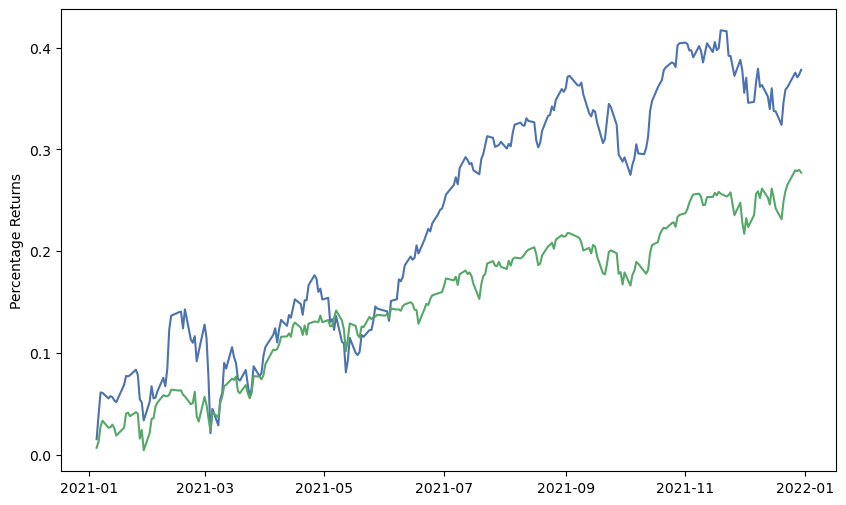

In [69]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_test_returns
benchmark_returns = spy_test_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
#plt.legend()
#plt.xlabel('Date')
plt.ylabel('Percentage Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy_IN_TV.png', transparent=True)